<a href="https://colab.research.google.com/github/sunhuanhuan920/ECE1512_2023F_ProjectRepo_Zhenhuan_Sun/blob/main/Project%20B/Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question 1

The paper I chose is "Towards Lossless Dataset Distillation via Difficulty-Aligned Trajectory Matching"

(a) Conventional dataset distillation methods become less effective when the total number of synthetic samples becomes larger. By performing experiments, this paper has given us insights about why dataset distillation become less effective when image per class (IPC) increases, by which they proposed a method that allows trajectory matching-based dataset distillation methods remain effective in both low and high IPC settings. In addition, the proposed method has managed to achieve lossless dataset distillation, allowing synthetic dataset become as effective as the original large dataset in terms of training models.

(b) Trajectory matching-based dataset distillation methods usually try to match all the update trajectories of models trained on both real and synthetic datasets across all training phases. However, the authors of this paper have found that matching late trajectories, i.e., learn "hard" patterns from original dataset, become more and more beneficial when IPC increases. While matching early trajectories, i.e., learn "easy" pattern from original dataset, is more beneficial with a low IPC and tends to be counterproductive with a high IPC. Building upon these insights, by calibrating the difficulty of the patterns to be learned, essentially avoiding learning patterns that are too easy or too hard, trajectory matchin-based method can remain effective in both low and high IPC settings through only matching the trajectories of a specified range, e.g., training phase.

(c) The method initially acquires an expert training trajectory, denoted as $\tau^* = \{\theta^*_t | 0 \leq t \leq n\}$, which is essentially a sequence of model parameters captured at different time throughout the training of a network on the real dataset. The method then sets a lower bound $t = T^-$ and an upper bound $t = T^+$ on the range of the expert trajectory to indicate which model parameters can be sampled for matching, allowing the method to control the difficulty of the patterns to be learned. In addition, soft labels is used to allow more information to be contained in the synthetic dataset. To alleviate the insatability issue that the utilization of soft labels bring, a floating upper bound $T$ which is small initially and gradually approaches $T^+$ as distillation progresses, is set on the sample range to generate only "easy" pattern at the early distillation stage and gradually generate harder patterns. In each iteration, the start model parameter $\theta^*_t$ and the target parameters $\theta^*_{t+M}$ are sampled from the sample range for trajectory matching. The model parameter $\hat{\theta}_{t+N}$ obtained after training on synthetic dataset for $N$ steps is generated and the synthetic dataset is then updated by performing backpropagation from loss function, defined as
$$L = \frac{\| \hat{\theta}_{t+N} - \theta^*_{t+M} \|^2_2}{\| \theta^*_{t} - \theta^*_{t+M} \|^2_2},$$
to compute the graidents.

(d)

**Advantages**: By aligning the difficulty of the patterns to be learned with the size of the synthetic dataset, the trajectory matching- based method can produce more consistent results for both small and large synthetic datasets than traditional dataset distillation methods. In addition, this method has the potential to achieve lossless distillation, which allows the quality of the trained model to be maintained while using a significantly reduced dataset.

**Disadvantages**: This method involves a complex process of setting different bounds, which increases the number of hyperparemeters needs to be tuned compared to the plain gradient matching algorithm we implemented in task 1. In addition, the adoption of soft labels in the synthetic dataset brings additional challenges, such as mislabeling and instability in distillation.

The method's ability to control the difficulty of the patterns to be learned for synthetic dataset makes it very promising for distilling datasets, since it is capable of learning patterns that will be useful in both small and large IPC settings. In cases where the original datasets are extremely large and diverse, e.g., ImageNet, A small IPC setting might be ineffective as the limited number of synthetic samples may lack the capacity to encapsulate all the information contained in ImageNet. But, by increasing the IPC and adopting this method to focus on learning the "hard" patterns, it might be possible to distill more informative information from the large dataset into the synthetic dataset. However, its real-world efficacy would largely depend on how well the informative patterns can be learned from such extensive data, and would require empirical validation.

# Question 2

**(a)**

In [1]:
! pip install import-ipynb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks/ECE1512/Project B/Project_B_Supp

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/ECE1512/Project B/Project_B_Supp/')

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/ECE1512/Project B/Project_B_Supp


In [3]:
import os
import random
import import_ipynb
from networks import ConvNet
from utils import get_dataset, get_network, distance_wb, get_time, evaluate_synset
from gsam import GSAM, ProportionScheduler
from reparam_module import ReparamModule
import torch
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset
import torch.nn as nn
from tqdm.auto import tqdm
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy
import time

importing Jupyter notebook from networks.ipynb
importing Jupyter notebook from utils.ipynb


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size_MNIST = 256
num_workers = 0

channel, im_size, num_classes, class_names, mean, std, train_MNIST_dataset, test_MNIST_dataset, test_MNIST_dataloader = get_dataset('MNIST', './data')
class_map = {x:x for x in range(num_classes)}

In [5]:
print(channel)
print(im_size)
print(num_classes)
print(class_names)
print(mean)
print(std)
print(class_map)

1
(28, 28)
10
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
[0.1307]
[0.3081]
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}


**Organize the real dataset**

In [ ]:
# Organize the real dataset
images_all = []
labels_all = []
indices_class = [[] for c in range(num_classes)]

for i in tqdm(range(len(train_MNIST_dataset))):
    sample = train_MNIST_dataset[i]
    images_all.append(torch.unsqueeze(sample[0], dim=0))
    labels_all.append(class_map[torch.tensor(sample[1]).item()])
images_all = torch.cat(images_all, dim=0).to("cpu")
labels_all = torch.tensor(labels_all, dtype=torch.long, device="cpu")

for i, lab in enumerate(labels_all):
    indices_class[lab].append(i)

def get_images(c, n):  # get random n images from class c
    idx_shuffle = np.random.permutation(indices_class[c])[:n]
    return images_all[idx_shuffle]

  0%|          | 0/60000 [00:00<?, ?it/s]

**Hyperparameters**

In [6]:
# Image per class
ipc = 10
# Initialization for synthetic learning rate (trainable)
lr_teacher = 0.01
# Learning rate for updating synthetic images
lr_img = 100
# Learning rate for updating learning rate
lr_lr = 1e-07
# Learning rate for updating label
lr_y = 2.
# Momentum for updating label
Momentum_y = 0.9

# Batch size for real data
batch_real = 256
# Batch size for training networks
batch_train = 256
# Batch size for training synthetic dataset
# batch_syn = num_classes * ipc
batch_syn = 16 # GPU RAM will be exhausted if batch_syn is greater than this
# Number of expert trajectories to generate
num_experts = 10
# Number of training epoch for each expert model
train_epochs = 50
# Parameter for optimizer and scheduler for training expert model
rho_max = 2.0
rho_min = 2.0
alpha = 0.4
adaptive = True
# The frequency of saving the trained model trajectories to drive
save_interval = 10
# Expert directory save path
save_path = '/content/drive/MyDrive/Colab Notebooks/ECE1512/Project B/Expert_Trajectory'
# Synthetic dataset save path
dataset_save_path = '/content/drive/MyDrive/Colab Notebooks/ECE1512/Project B/Task2_Synthetic_Dataset'

# Number of distillation step to perform
Iteration = 1000
# Maximum epoch to start with
max_start_epoch = 25
current_max_start_epoch = 20
# Minimum epoch to start with
min_start_epoch = 0
expansion_end_epoch = 3000
# Update times between the start and target expert parameters (M)
expert_epochs = 2
# Update times of the student network in each inner optimization
syn_steps = 80
# Update threshold
threshold = 1.0

Label_Model_Timestamp = -1

**Obtain expert trajectories**

Code reference:
1.   https://github.com/GzyAftermath/DATM/blob/main/utils/utils_gsam.py#L374
2.   https://github.com/GzyAftermath/DATM/blob/main/buffer/buffer_FTD.py#L103



In [ ]:
def epoch(mode, dataloader, net, optimizer, criterion, device, scheduler):
    loss_avg, acc_avg, num_exp = 0, 0, 0
    net = net.to(device)

    if mode == 'train':
        net.train()
    else:
        net.eval()

    for i_batch, datum in enumerate(dataloader):
        img = datum[0].float().to(device)
        lab = datum[1].long().to(device)

        n_b = lab.shape[0]

        ##GSAM
        if mode == 'train':
            def loss_fn(predictions, targets):
                #return smooth_crossentropy(predictions, targets,smoothing=args.label_smoothing).mean()
                return criterion(predictions, targets)

            optimizer.set_closure(loss_fn, img, lab)
            output, loss = optimizer.step()
            #print(loss)

            with torch.no_grad():
                acc = np.sum(np.equal(np.argmax(output.cpu().data.numpy(), axis=-1), lab.cpu().data.numpy()))
                loss_avg += loss.item()*n_b
                acc_avg += acc
                num_exp += n_b

                scheduler.step()
                optimizer.update_rho_t()
        else:
            with torch.no_grad():
                output = net(img)
                #loss = smooth_crossentropy(output, lab)
                loss = criterion(output, lab)
                acc = np.sum(np.equal(np.argmax(output.cpu().data.numpy(), axis=-1), lab.cpu().data.numpy()))
                loss_avg += loss.item()*n_b
                acc_avg += acc
                num_exp += n_b


    loss_avg /= num_exp
    acc_avg /= num_exp

    return loss_avg, acc_avg

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
trajectories = []

# Prepare real dataset for training expert models and obtain expert trajectories
dst_real_train = TensorDataset(copy.deepcopy(images_all.detach()), copy.deepcopy(labels_all.detach()))
trainloader = torch.utils.data.DataLoader(dst_real_train, batch_size=batch_train, shuffle=True, num_workers=0)

for it in range(0, num_experts):

    # Initialize a random expert model
    teacher_net = get_network("ConvNet", channel, num_classes, im_size).to(device).to(device)
    teacher_net.train()
    lr = lr_teacher

    base_optimizer = torch.optim.SGD(teacher_net.parameters(), lr=lr, momentum=0, weight_decay=0)
    scheduler = torch.optim.lr_scheduler.StepLR(base_optimizer,step_size=train_epochs*len(trainloader),gamma=1)
    rho_scheduler = ProportionScheduler(pytorch_lr_scheduler=scheduler, max_lr=lr, min_lr=lr,
        max_value=rho_max, min_value=rho_min)
    teacher_optim = GSAM(params=teacher_net.parameters(), base_optimizer=base_optimizer,
            model=teacher_net, gsam_alpha=alpha, rho_scheduler=rho_scheduler, adaptive=adaptive)


    teacher_optim.zero_grad()
    timestamps = []
    # Store the initial state of the current expert model's parameters
    timestamps.append([p.detach().cpu() for p in teacher_net.parameters()])

    lr_schedule = [train_epochs // 2 + 1]
    for e in range(train_epochs):

        # Training accuracy and loss
        train_loss, train_acc = epoch("train", dataloader=trainloader, net=teacher_net, optimizer=teacher_optim,
                                    criterion=criterion, device=device, scheduler=scheduler)

        # Test accuracy and loss
        test_loss, test_acc = epoch("test", dataloader=test_MNIST_dataloader, net=teacher_net, optimizer=None,
                                    criterion=criterion, device=device, scheduler=scheduler)

        if (e+1) % 10 == 0:
            print("Expert: {}\tEpoch: {}\tTrain Acc: {:.3f}\tTest Acc: {:.3f}".format(it+1, e+1, train_acc, test_acc))

        # Store the current state of the expert model's parameters
        timestamps.append([p.detach().cpu() for p in teacher_net.parameters()])


    # Store each expert model's parameter states over all train_epochs
    trajectories.append(timestamps)

    # The collected trajectories are saved as a "replay buffer" file in save_dir
    if len(trajectories) == save_interval:
        n = 0
        while os.path.exists(os.path.join(save_path, "replay_buffer_{}.pt".format(n))):
            n += 1
        print("Saving {}".format(os.path.join(save_path, "replay_buffer_{}.pt".format(n))))
        torch.save(trajectories, os.path.join(save_path, "replay_buffer_{}.pt".format(n)))
        trajectories = []

Expert: 1	Epoch: 10	Train Acc: 0.983	Test Acc: 0.984
Expert: 1	Epoch: 20	Train Acc: 0.989	Test Acc: 0.989
Expert: 1	Epoch: 30	Train Acc: 0.992	Test Acc: 0.992
Expert: 1	Epoch: 40	Train Acc: 0.993	Test Acc: 0.992
Expert: 1	Epoch: 50	Train Acc: 0.994	Test Acc: 0.993
Expert: 2	Epoch: 10	Train Acc: 0.983	Test Acc: 0.985
Expert: 2	Epoch: 20	Train Acc: 0.989	Test Acc: 0.989
Expert: 2	Epoch: 30	Train Acc: 0.992	Test Acc: 0.991
Expert: 2	Epoch: 40	Train Acc: 0.993	Test Acc: 0.992
Expert: 2	Epoch: 50	Train Acc: 0.994	Test Acc: 0.993
Expert: 3	Epoch: 10	Train Acc: 0.984	Test Acc: 0.985
Expert: 3	Epoch: 20	Train Acc: 0.989	Test Acc: 0.990
Expert: 3	Epoch: 30	Train Acc: 0.992	Test Acc: 0.992
Expert: 3	Epoch: 40	Train Acc: 0.993	Test Acc: 0.993
Expert: 3	Epoch: 50	Train Acc: 0.994	Test Acc: 0.993
Expert: 4	Epoch: 10	Train Acc: 0.982	Test Acc: 0.984
Expert: 4	Epoch: 20	Train Acc: 0.988	Test Acc: 0.988
Expert: 4	Epoch: 30	Train Acc: 0.991	Test Acc: 0.990
Expert: 4	Epoch: 40	Train Acc: 0.993	Test Acc:

**Access expert trajectories**

Code reference:
1.   https://github.com/GzyAftermath/DATM/blob/main/distill/DATM.py



In [ ]:
# Since I only have ten expert trajectory, all expert trajectories are loaded
expert_dir = save_path
expert_files = []
n = 0

# Accumulates all replay buffer files into list
while os.path.exists(os.path.join(expert_dir, "replay_buffer_{}.pt".format(n))):
    expert_files.append(os.path.join(expert_dir, "replay_buffer_{}.pt".format(n)))
    n += 1
if n == 0:
    raise AssertionError("No buffers detected at {}".format(expert_dir))

file_idx = 0
expert_idx = 0

expert_id = [i for i in range(len(expert_files))]
random.shuffle(expert_id)

print("loading file {}".format(expert_files[expert_id[file_idx]]))
buffer = torch.load(expert_files[expert_id[file_idx]])
buffer_id = [i for i in range(len(buffer))]
random.shuffle(buffer_id)

loading file /content/drive/MyDrive/Colab Notebooks/ECE1512/Project B/Expert_Trajectory/replay_buffer_0.pt


**Prepare synthetic images for condensation**

Code reference:
1.   https://github.com/GzyAftermath/DATM/blob/main/distill/DATM.py
2.   https://github.com/GzyAftermath/DATM/blob/main/reparam_module.py#L9

In [ ]:
# Initialize the synthetic images
image_syn = torch.randn(size=(num_classes * ipc, channel, im_size[0], im_size[1]), dtype=torch.float)

# for c in range(num_classes):
#     image_syn.data[c * ipc:(c + 1) * ipc] = get_images(c, ipc).detach().data

# Initialize the synthetic images from real image
# Only sample images that expert model can predict correctly
Temp_net = get_network('ConvNet', channel, num_classes, im_size).to(device)  # get a random model
Temp_net.eval()
Temp_net = ReparamModule(Temp_net)
Temp_net.eval()
logits=[]
label_expert_files = expert_files
temp_params = torch.load(label_expert_files[0])[0][Label_Model_Timestamp]
temp_params = torch.cat([p.data.to(device).reshape(-1) for p in temp_params], 0)

for c in range(num_classes):
    data_for_class_c = get_images(c, len(indices_class[c])).detach().data
    n, _, w, h = data_for_class_c.shape
    selected_num = 0
    select_times = 0
    cur=0
    temp_img = None
    Wrong_Predicted_Img = None
    batch_size = 256
    index = []

    # Procee images in batches to select ipc number of images that the model can
    # correctly predict as class c
    while len(index)<ipc:
        print(str(c)+'.'+str(select_times)+'.'+str(cur))
        current_data_batch = data_for_class_c[batch_size*select_times : batch_size*(select_times+1)].detach().to(device)
        if batch_size*select_times > len(data_for_class_c):
            select_times = 0
            cur+=1
            temp_params = torch.load(label_expert_files[int(cur/10)%10])[cur%10][Label_Model_Timestamp]
            temp_params = torch.cat([p.data.to(device).reshape(-1) for p in temp_params], 0).to(device)
            continue
        logits = Temp_net(current_data_batch, flat_param=temp_params).detach()
        prediction_class = np.argmax(logits.cpu().data.numpy(), axis=-1)
        for i in range(len(prediction_class)):
            if prediction_class[i]==c and len(index)<ipc:
                index.append(batch_size*select_times+i)
                index=list(set(index))
        select_times+=1
        if len(index) == ipc:
            temp_img = torch.index_select(data_for_class_c, dim=0, index=torch.tensor(index))
            break
    image_syn.data[c * ipc:(c + 1) * ipc] = temp_img.detach()

image_syn = image_syn.detach().to(device).requires_grad_(True)
syn_lr = torch.tensor(lr_teacher).to(device)
syn_lr = syn_lr.detach().to(device).requires_grad_(True)

optimizer_img = torch.optim.SGD([image_syn], lr=lr_img, momentum=0.5)
optimizer_lr = torch.optim.SGD([syn_lr], lr=lr_lr, momentum=0.5)
optimizer_img.zero_grad()

0.0.0
1.0.0
2.0.0
3.0.0
4.0.0
5.0.0
6.0.0
7.0.0
8.0.0
9.0.0


In [ ]:
print(image_syn.shape)

torch.Size([100, 1, 28, 28])


**Prepare synthetic labels for condensation**

Code reference:
1.   https://github.com/GzyAftermath/DATM/blob/main/distill/DATM.py
2.   https://github.com/GzyAftermath/DATM/blob/main/reparam_module.py#L9

In [ ]:
# Initialize the synthetic labels
label_syn = torch.tensor([np.ones(ipc)*i for i in range(num_classes)], dtype=torch.long, requires_grad=False, device=device).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]

# Compute cross-entropy loss for inputs wiht soft targets
def SoftCrossEntropy(inputs, target, reduction='average'):
    input_log_likelihood = -F.log_softmax(inputs, dim=1)
    target_log_likelihood = F.softmax(target, dim=1)
    batch = inputs.shape[0]
    loss = torch.sum(torch.mul(input_log_likelihood, target_log_likelihood)) / batch
    return loss

criterion = SoftCrossEntropy

# Avoid mislabeling by sampling samples that can be correctly classified by
# expert model
Temp_net = get_network('ConvNet', channel, num_classes, im_size).to(device)  # get a random model
Temp_net.eval()
Temp_net = ReparamModule(Temp_net)
Temp_net.eval()
logits=[]
batch_size = 256

for i in range(len(label_expert_files)):
    Temp_Buffer = torch.load(label_expert_files[i])
    for j in Temp_Buffer:
        temp_logits = None
        for select_times in range((len(image_syn)+batch_size-1)//batch_size):
            current_data_batch = image_syn[batch_size*select_times : batch_size*(select_times+1)].detach().to(device)
            Temp_params = j[Label_Model_Timestamp]
            Initialize_Labels_params = torch.cat([p.data.to(device).reshape(-1) for p in Temp_params], 0)
            # Compute predictions using Temp_net with parameter from Temp_buffer
            Initialized_Labels = Temp_net(current_data_batch, flat_param=Initialize_Labels_params)
            if temp_logits == None:
                temp_logits = Initialized_Labels.detach()
            else:
                temp_logits = torch.cat((temp_logits, Initialized_Labels.detach()),0)
        logits.append(temp_logits.detach().cpu())

# Compute average logits
logits_tensor = torch.stack(logits)
true_labels = label_syn.cpu()
predicted_labels = torch.argmax(logits_tensor, dim=2).cpu()
correct_predictions = predicted_labels == true_labels.view(1, -1)
mask = correct_predictions.unsqueeze(2)
correct_logits = logits_tensor * mask.float()
correct_logits_per_model = correct_logits.sum(dim=0)
num_correct_images_per_model = correct_predictions.sum(dim=0, dtype=torch.float)
average_logits_per_image = correct_logits_per_model / num_correct_images_per_model.unsqueeze(1)
Initialized_Labels = average_logits_per_image

label_syn = copy.deepcopy(Initialized_Labels.detach()).to(device).requires_grad_(True)
label_syn.requires_grad=True
label_syn = label_syn.to(device)

optimizer_y = torch.optim.SGD([label_syn], lr=lr_y, momentum=Momentum_y)

del Temp_net

In [ ]:
print(label_syn.shape)

torch.Size([100, 10])


**Difficulty-Aligned Trajectory Matching Algorithm**

Code reference:
1.   https://github.com/GzyAftermath/DATM/blob/main/distill/DATM.py

In [ ]:
# Save synthetic data samples and labels and learning rate for learning on this
# condensed dataset
data_save = []
# Save initial synthetic dataset and learning rate
data_save.append([copy.deepcopy(image_syn.detach().cpu()), copy.deepcopy(label_syn.detach().cpu()), copy.deepcopy(syn_lr.detach().cpu())])

for it in range(0, Iteration):

    # Initialize model
    student_net = get_network('ConvNet', channel=channel, num_classes=num_classes, im_size=im_size).to(device)
    student_net = ReparamModule(student_net)
    student_net.train()
    num_params = sum([np.prod(p.size()) for p in (student_net.parameters())])

    # Load expert trajectories
    expert_trajectory = buffer[buffer_id[expert_idx]]
    expert_idx += 1
    if expert_idx == len(buffer):
        expert_idx = 0
        file_idx += 1
        if file_idx == len(expert_files):
            file_idx = 0
            random.shuffle(expert_id)
        # print("loading file {}".format(expert_files[expert_id[file_idx]]))
        random.shuffle(buffer_id)

    # Only match easy trajactories in the early stage
    # Determine upper bound variable
    # Dynamically adjust upper bound based on the progress
    Upper_Bound = current_max_start_epoch + int((max_start_epoch-current_max_start_epoch) * it/(expansion_end_epoch))
    Upper_Bound = min(Upper_Bound, max_start_epoch)

    # Select a random value of t within the specified range
    start_epoch = np.random.randint(min_start_epoch, Upper_Bound)

    # Extract start model parameters and target model parameters for the matching
    # from expert trajectories
    starting_params = expert_trajectory[start_epoch]
    target_params = expert_trajectory[start_epoch+expert_epochs]

    # Flatten and concatenates model parameters
    target_params = torch.cat([p.data.to(device).reshape(-1) for p in target_params], 0)
    student_params = [torch.cat([p.data.to(device).reshape(-1) for p in starting_params], 0).requires_grad_(True)]
    starting_params = torch.cat([p.data.to(device).reshape(-1) for p in starting_params], 0)

    syn_images = image_syn
    y_hat = label_syn

    param_loss_list = []
    param_dist_list = []
    indices_chunks = []

    for step in range(syn_steps):

        # Create new permutation of indices and splits them into batches
        if not indices_chunks:
            indices = torch.randperm(len(syn_images))
            indices_chunks = list(torch.split(indices, batch_syn))

        these_indices = indices_chunks.pop()

        x = syn_images[these_indices]
        this_y = y_hat[these_indices]

        # Forward pass
        forward_params = student_params[-1]
        x = student_net(x, flat_param=forward_params)
        ce_loss = criterion(x, this_y)

        # Backward pass
        grad = torch.autograd.grad(ce_loss, student_params[-1], create_graph=True)[0]

        # Update
        student_params.append(student_params[-1] - syn_lr * grad)

    # Compute trajectory matching loss
    param_loss = torch.tensor(0.0).to(device)
    param_dist = torch.tensor(0.0).to(device)

    param_loss += torch.nn.functional.mse_loss(student_params[-1], target_params, reduction="sum")
    param_dist += torch.nn.functional.mse_loss(starting_params, target_params, reduction="sum")

    param_loss_list.append(param_loss)
    param_dist_list.append(param_dist)

    param_loss /= num_params
    param_dist /= num_params

    param_loss /= param_dist

    grand_loss = param_loss

    optimizer_img.zero_grad()
    optimizer_lr.zero_grad()
    optimizer_y.zero_grad()

    grand_loss.backward()

    if grand_loss<=threshold:
        optimizer_y.step()
        optimizer_img.step()
        optimizer_lr.step()

    for _ in student_params:
        del _

    if (it+1) % 100 == 0:
        print('%s iter = %04d, loss = %.4f, start_epoch = %d' % (get_time(), it+1, grand_loss.item(), start_epoch))
        data_save.append([copy.deepcopy(image_syn.detach().cpu()), copy.deepcopy(label_syn.detach().cpu()), copy.deepcopy(syn_lr.detach().cpu())])

    if it == Iteration-1:
        torch.save(data_save, os.path.join(dataset_save_path, 'Task2_Dataset.pt'))

[2023-12-01 20:53:12] iter = 0100, loss = 0.9609, start_epoch = 15
[2023-12-01 20:54:39] iter = 0200, loss = 0.8480, start_epoch = 7
[2023-12-01 20:56:06] iter = 0300, loss = 0.9536, start_epoch = 17
[2023-12-01 20:57:33] iter = 0400, loss = 0.8750, start_epoch = 12
[2023-12-01 20:59:00] iter = 0500, loss = 0.6376, start_epoch = 3
[2023-12-01 21:00:27] iter = 0600, loss = 0.8567, start_epoch = 12
[2023-12-01 21:01:55] iter = 0700, loss = 0.8254, start_epoch = 12
[2023-12-01 21:03:22] iter = 0800, loss = 0.7667, start_epoch = 9
[2023-12-01 21:04:50] iter = 0900, loss = 0.5605, start_epoch = 3
[2023-12-01 21:06:17] iter = 1000, loss = 0.7614, start_epoch = 9


**Display learned condensed images**

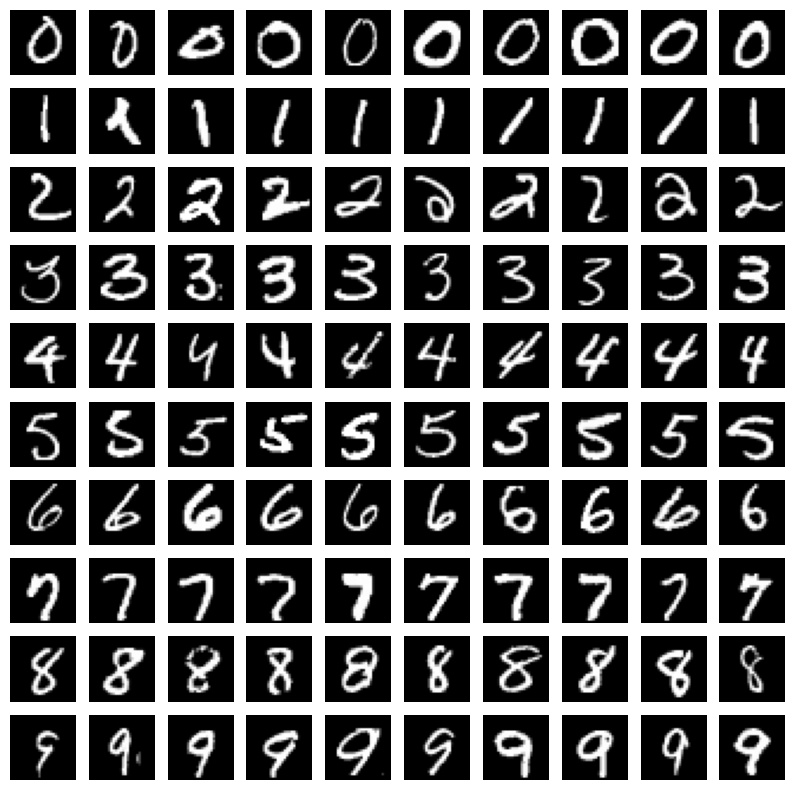

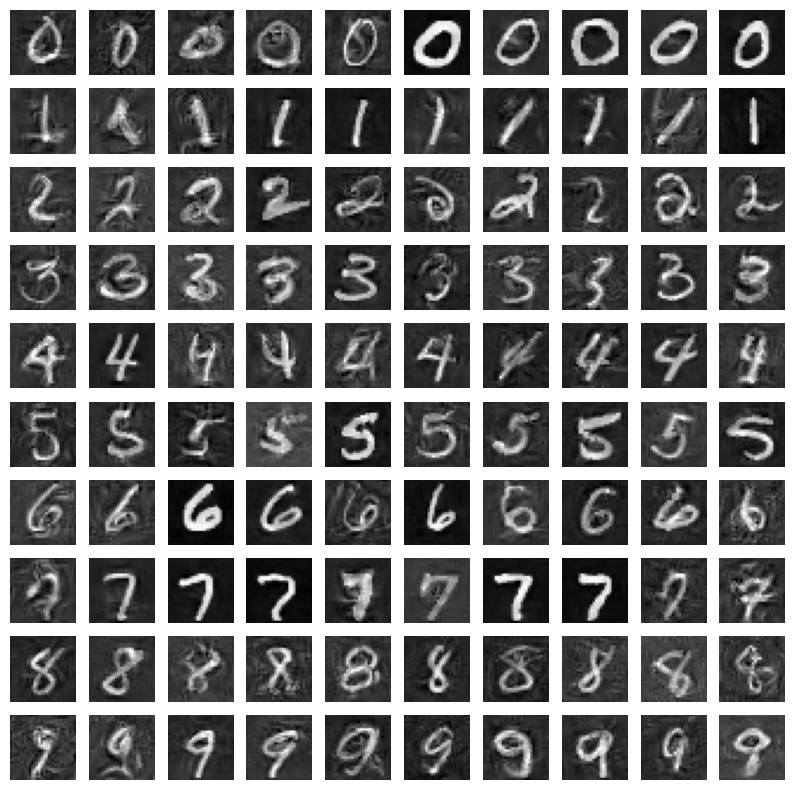

In [7]:
# Load the synthetic dataset
synthetic_data = torch.load('/content/drive/MyDrive/Colab Notebooks/ECE1512/Project B/Task2_Synthetic_Dataset/Task2_Dataset.pt')

synthetic_images = {
    'Iteration_0': synthetic_data[0][0],
    'Iteration_1000': synthetic_data[10][0]
}

# Plot
for iteration, synthetic_images in synthetic_images.items():

    fig, axes = plt.subplots(nrows=num_classes, ncols=ipc, figsize=(ipc, num_classes))
    # fig.suptitle(iteration)

    for i, ax in enumerate(axes.flat):
        img = synthetic_images[i].numpy().squeeze()
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    print("\n")

    plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/ECE1512/Project B/Figures/T2_2a_MNIST_{iteration}.png', dpi=300, bbox_inches='tight')

    plt.show()

**Train model on condensed dataset**

In [ ]:
batch_size_MNIST = 256
num_workers = 0

channel, im_size, num_classes, class_names, mean, std, train_MNIST_dataset, test_MNIST_dataset, test_MNIST_dataloader = get_dataset('MNIST', './data')
class_map = {x:x for x in range(num_classes)}

ConvNet3 = get_network('ConvNet', channel=channel, num_classes=num_classes, im_size=im_size)

print(ConvNet3)

print(f"\nThe model is on CUDA: {next(ConvNet3.parameters()).is_cuda}\n")

ConvNet(
  (features): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3))
    (1): GroupNorm(128, 128, eps=1e-05, affine=True)
    (2): ReLU(inplace=True)
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): GroupNorm(128, 128, eps=1e-05, affine=True)
    (6): ReLU(inplace=True)
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): GroupNorm(128, 128, eps=1e-05, affine=True)
    (10): ReLU(inplace=True)
    (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Linear(in_features=2048, out_features=10, bias=True)
)

The model is on CUDA: True



In [9]:
def SoftCrossEntropy(inputs, target, reduction='average'):
    input_log_likelihood = -F.log_softmax(inputs, dim=1)
    target_log_likelihood = F.softmax(target, dim=1)
    batch = inputs.shape[0]
    loss = torch.sum(torch.mul(input_log_likelihood, target_log_likelihood)) / batch
    return loss

In [ ]:
image_syn = synthetic_data[10][0]
label_syn = synthetic_data[10][1]
lr_syn = float(synthetic_data[10][2])

dst_syn_train = TensorDataset(image_syn, label_syn)
trainloader = torch.utils.data.DataLoader(dst_syn_train, batch_size=batch_size_MNIST, shuffle=True, num_workers=0)

num_epochs = 20
num_training_steps = num_epochs * len(trainloader)
train_criterion = SoftCrossEntropy
# train_criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(ConvNet3.parameters(), lr=lr_syn, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

start_time = time.time()
progress_bar = tqdm(range(num_training_steps),
                    bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{rate_fmt}{postfix}]')

for epoch in range(num_epochs):

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        outputs = ConvNet3(images)
        loss = train_criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        progress_bar.update(1)
        precise_elapsed_time = time.time() - start_time
        progress_bar.set_description(f"Elapsed Time: {precise_elapsed_time:.2f} seconds")

    if (epoch+1) % 5 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

progress_bar.close()

  0%|          | 0/20 [?it/s]

Epoch 5, Loss: 1.8297
Epoch 10, Loss: 1.3410
Epoch 15, Loss: 1.1064
Epoch 20, Loss: 1.0471


In [ ]:
print(progress_bar.desc)

Elapsed Time: 0.16 seconds: 


**Test model on condensed dataset**

In [ ]:
ConvNet3.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_MNIST_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = ConvNet3(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the 10000 test images: {accuracy:.2f} %')

Accuracy of the model on the 10000 test images: 86.48 %


**(b)**

To alleviate the impact of training randomness, such as the random shuffling of the training dataset, on the comparison between ConvNet3 models trained on condensed datasets from Task 1 and Task 2, we conducted 100 independent training sessions for the model on each condensed dataset using identical training settings, with the model being trained for 50 epochs in each of these repeated sessions. We subsequently illustrated the results by creating plots that showcase the test accuracies achieved across all trials, as well as the longest training duration recorded in any of the experiments. These visualizations compare the test performance and training efficiency of the ConvNet3 models trained on the condensed datasets obtained from both Task 1 and Task 2.

In [9]:
batch_size_MNIST = 256
num_workers = 0

channel, im_size, num_classes, class_names, mean, std, train_MNIST_dataset, test_MNIST_dataset, test_MNIST_dataloader = get_dataset('MNIST', './data')
class_map = {x:x for x in range(num_classes)}

In [16]:
synthetic_data_Task_1 = torch.load('/content/drive/MyDrive/Colab Notebooks/ECE1512/Project B/Synthetic_MNIST_from_real/MNIST_CONVNET3_10ipc.pt')

image_syn = synthetic_data_Task_1[10][0]
label_syn = synthetic_data_Task_1[10][1]
lr_syn = 0.01

num_epochs = 50
test_accuracies_T1_dataset = []
training_times_T1_dataset = []

print("Task 1 Condensed Dataset:\n")
for it in range(100):

    ConvNet3 = get_network('ConvNet', channel=channel, num_classes=num_classes, im_size=im_size)
    dst_syn_train = TensorDataset(image_syn, label_syn)
    trainloader = torch.utils.data.DataLoader(dst_syn_train, batch_size=batch_size_MNIST, shuffle=True, num_workers=0)

    train_criterion = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.SGD(ConvNet3.parameters(), lr=lr_syn, momentum=0.9, weight_decay=0.0005)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    start_time = time.time()
    for epoch in range(num_epochs):

        ConvNet3.train()
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            outputs = ConvNet3(images)
            loss = train_criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

    training_time = time.time() - start_time
    training_times_T1_dataset.append(training_time)

    # Set the model to evaluation mode
    ConvNet3.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_MNIST_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = ConvNet3(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total

    if (it+1) % 10 == 0:
        print(f'Iteration: {it+1:<3} | Test Accuracy: {accuracy:.2f} %')

    test_accuracies_T1_dataset.append(accuracy)

Task 1 Condensed Dataset:

Iteration: 10  | Test Accuracy: 94.35 %
Iteration: 20  | Test Accuracy: 93.84 %
Iteration: 30  | Test Accuracy: 93.66 %
Iteration: 40  | Test Accuracy: 93.85 %
Iteration: 50  | Test Accuracy: 94.11 %
Iteration: 60  | Test Accuracy: 93.64 %
Iteration: 70  | Test Accuracy: 94.26 %
Iteration: 80  | Test Accuracy: 93.49 %
Iteration: 90  | Test Accuracy: 93.82 %
Iteration: 100 | Test Accuracy: 94.09 %


In [15]:
synthetic_data_Task_2 = torch.load('/content/drive/MyDrive/Colab Notebooks/ECE1512/Project B/Task2_Synthetic_Dataset/Task2_Dataset.pt')

image_syn = synthetic_data_Task_2[10][0]
label_syn = synthetic_data_Task_2[10][1]
lr_syn = float(synthetic_data_Task_2[10][2])

num_epochs = 50
test_accuracies_T2_dataset = []
training_times_T2_dataset = []

print("Task 2 Condensed Dataset:\n")
for it in range(100):

    ConvNet3 = get_network('ConvNet', channel=channel, num_classes=num_classes, im_size=im_size)
    dst_syn_train = TensorDataset(image_syn, label_syn)
    trainloader = torch.utils.data.DataLoader(dst_syn_train, batch_size=batch_size_MNIST, shuffle=True, num_workers=0)

    train_criterion = SoftCrossEntropy
    optimizer = torch.optim.SGD(ConvNet3.parameters(), lr=lr_syn, momentum=0.9, weight_decay=0.0005)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    start_time = time.time()
    for epoch in range(num_epochs):

        ConvNet3.train()
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            outputs = ConvNet3(images)
            loss = train_criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

    training_time = time.time() - start_time
    training_times_T2_dataset.append(training_time)

    # Set the model to evaluation mode
    ConvNet3.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_MNIST_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = ConvNet3(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total

    if (it+1) % 10 == 0:
        print(f'Iteration: {it+1:<3} | Test Accuracy: {accuracy:.2f} %')

    test_accuracies_T2_dataset.append(accuracy)

Task 2 Condensed Dataset:

Iteration: 10  | Test Accuracy: 94.76 %
Iteration: 20  | Test Accuracy: 94.65 %
Iteration: 30  | Test Accuracy: 94.63 %
Iteration: 40  | Test Accuracy: 94.45 %
Iteration: 50  | Test Accuracy: 95.24 %
Iteration: 60  | Test Accuracy: 94.87 %
Iteration: 70  | Test Accuracy: 94.91 %
Iteration: 80  | Test Accuracy: 94.90 %
Iteration: 90  | Test Accuracy: 94.94 %
Iteration: 100 | Test Accuracy: 95.51 %


Average test accuracy achieved by Task 1 condensed dataset: 93.821
Average test accuracy achieved by Task 2 condensed dataset: 94.77190000000004


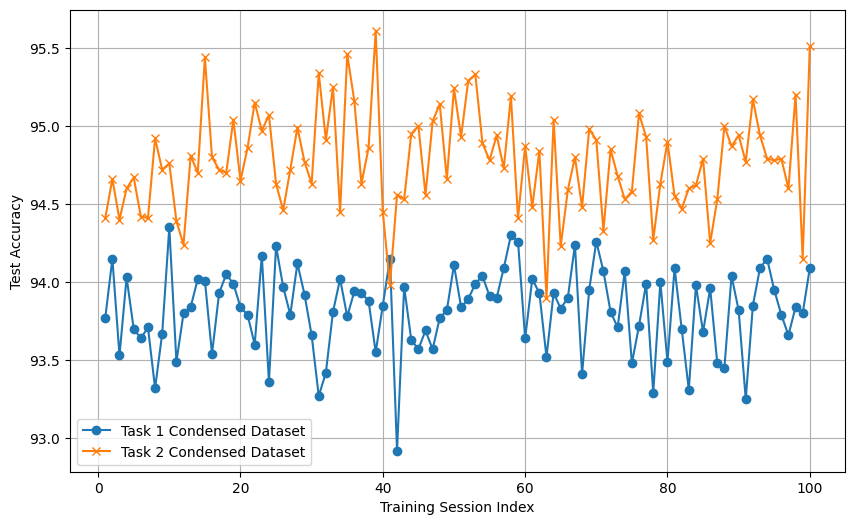

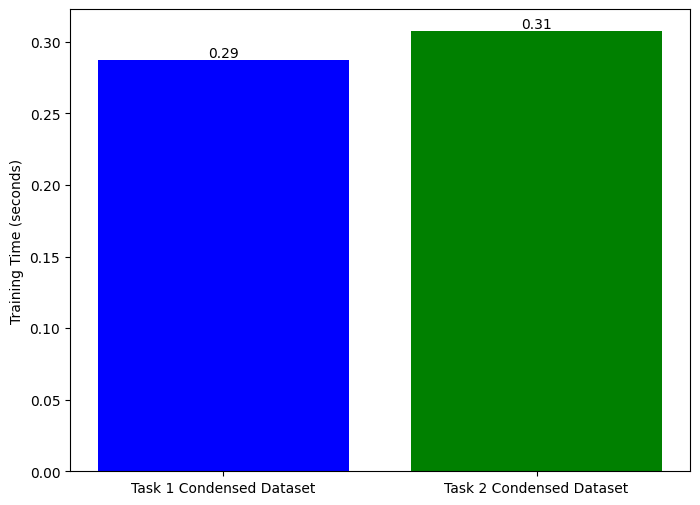

In [19]:
# Number of iterations
iterations = list(range(1, len(test_accuracies_T1_dataset) + 1))

average_test_accuracies_T1 = sum(test_accuracies_T1_dataset) / len(test_accuracies_T1_dataset)
average_test_accuracies_T2 = sum(test_accuracies_T2_dataset) / len(test_accuracies_T2_dataset)

print(f'Average test accuracy achieved by Task 1 condensed dataset: {average_test_accuracies_T1}')
print(f'Average test accuracy achieved by Task 2 condensed dataset: {average_test_accuracies_T2}')

plt.figure(figsize=(10, 6))
plt.plot(iterations, test_accuracies_T1_dataset, label='Task 1 Condensed Dataset', marker='o')
plt.plot(iterations, test_accuracies_T2_dataset, label='Task 2 Condensed Dataset', marker='x')

plt.xlabel('Training Session Index')
plt.ylabel('Test Accuracy')
# plt.title('Test Accuracies of ConvNet3 Models on Task 1 and Task 2 Datasets')
plt.legend()
plt.grid(True)
plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/ECE1512/Project B/Figures/T2_2b_1.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculating the average training times
max_training_time_T1 = max(training_times_T1_dataset)
max_training_time_T2 = max(training_times_T2_dataset)

# Data for plotting
datasets = ['Task 1 Condensed Dataset', 'Task 2 Condensed Dataset']
max_times = [max_training_time_T1, max_training_time_T2]

plt.figure(figsize=(8, 6))
bars = plt.bar(datasets, max_times, color=['blue', 'green'])

# plt.xlabel('Dataset')
plt.ylabel('Training Time (seconds)')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')
# plt.title('Longest Training Times found by training on Task 1 and Task 2 Datasets')
plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/ECE1512/Project B/Figures/T2_2b_2.png', dpi=300, bbox_inches='tight')
plt.show()

**Train and Test performance**: As shown in the plot above, using the same training settings, the ConvNet3 model, when trained on a condensed dataset learned by the difficulty-aligned trajectory matching algorithm, demonstrated slighted improved accuracy performance (94.8% on average) on the test set. This performance was achieved in a comparable training time to that of the ConvNet3 model trained on a condensed dataset learned using the conventional gradient matching algorithm, which achieved an accuracy of 93.7% on average. The modest enhancement in test accuracy can be attributed to the limitation that we distilled only 10 images per class for both Task 1 and Task 2. As noted in the paper, there is only so much information that can be encapsulated in such a small set of samples. Thus, these condensed dataset's generalization ability may be limited.

**Recognition ability**: As shown in both condensed images figures, the condesned images for MNIST dataset, initialized with real images, obtained in Task 1 and Task 2 are both recognizable. While the dataset distillation process in each task has modified the images to a certain degree, it is observed that these alterations are more pronounced in Task 2, which utilized the Difficulty-Aligned Trajectory Matching algorithm. For instance, the rightmost image in the 8th row of the condensed dataset, as depicted in the figure, seems to incorporate different orientations of the digit "8" within a single image.



We also evaluated the ability of the Task 2 condensed dataset to generalize across different architectures. The result indicate that the Task 2 condensed MNIST dataset, with 10 images per class, successfully adapted to the AlexNet architecture, achieving a test accuracy of 91.90% on the test set.

In [11]:
AlexNet = get_network('AlexNet', channel=channel, num_classes=num_classes, im_size=im_size)
batch_size = 32

# Train network on condensed dataset
image_syn_train, label_syn_train = synthetic_data[10][0], synthetic_data[10][1]
dst_syn_train = TensorDataset(image_syn_train, label_syn_train)
trainloader = torch.utils.data.DataLoader(dst_syn_train, batch_size=batch_size, shuffle=True, num_workers=0)

num_epochs = 100
num_training_steps = num_epochs * len(trainloader)
criterion = SoftCrossEntropy
optimizer = torch.optim.SGD(AlexNet.parameters(), lr=float(synthetic_data[10][2]), momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

start_time = time.time()
progress_bar = tqdm(range(num_training_steps),
                    bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{rate_fmt}{postfix}]')

for epoch in range(num_epochs):

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        outputs = AlexNet(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        progress_bar.update(1)

        precise_elapsed_time = time.time() - start_time
        progress_bar.set_description(f"Elapsed Time: {precise_elapsed_time:.2f} seconds")

    if (epoch+1) % 5 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

progress_bar.close()

  0%|          | 0/400 [?it/s]

Epoch 5, Loss: 2.3358
Epoch 10, Loss: 2.2139
Epoch 15, Loss: 1.4212
Epoch 20, Loss: 1.6200
Epoch 25, Loss: 1.8762
Epoch 30, Loss: 0.8848
Epoch 35, Loss: 1.1984
Epoch 40, Loss: 1.2931
Epoch 45, Loss: 1.0183
Epoch 50, Loss: 0.1450
Epoch 55, Loss: 0.3084
Epoch 60, Loss: 0.0084
Epoch 65, Loss: 0.0077
Epoch 70, Loss: 0.0085
Epoch 75, Loss: 0.0299
Epoch 80, Loss: 0.0073
Epoch 85, Loss: 0.0464
Epoch 90, Loss: 0.0084
Epoch 95, Loss: 0.2203
Epoch 100, Loss: 0.0310


In [12]:
AlexNet.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_MNIST_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = AlexNet(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the 10000 test images: {accuracy:.2f} %')

Accuracy of the model on the 10000 test images: 91.90 %


# Lossless Dataset Distillation

As noted in the paper, a small synthetic dataset with a low IPC leads to a loss of information from the original dataset. This loss is due to the limited capacity of the synthetic dataset to encapsulate the full dataset's information, resulting in suboptimal performance of models trained on these smaller synthetic datasets compared to those trained on the complete dataset. Thus, to achieve lossless dataset distillation, we need to augment the information capacity of the synthetic dataset, we do this by increasing the IPC (Images Per Class) settings during dataset distillation.

Additionally, it's noteworthy that the authors of the paper effectively achieved lossless distillation on the CIFAR-10 dataset by condensing the dataset to one-fifth of its original volumn. Like the CIFAR10, the MNIST dataset that we are working on also comprises 60,000 images distributed over 10 classes. Thus, we first set the size of the synthetic dataset to $60000 \cdot \frac{1}{5} = 12000$ and ipc to $1200$, and leave the other hyperparameters untouched. The test performance under such setting is 98.89% with 11.56 seconds of training time, which is very close the test accuracy performance (99.38%) achieved by training on the original dataset for 291.79 seconds.

Informed by this observation, we further increase the size of the synthetic dataset to $60000 \cdot \frac{1}{2} = 30000$ and ipc to $3000$. The outcome demonstrates that training in this specific setup yielded an accuracy of 99.10% on the test set, accomplished in just 29.14 seconds of training time. Nevertheless, we refrained from expanding the size of the synthetic dataset further. This decision was based on the observation that enlarging the dataset leads to only a marginal enhancement in test performance (around +/- 0.05%). Additionally, increasing the dataset's size would contradict the objective of dataset distillation.

In summary, our attempt to create a synthetic dataset enabling a model trained on it to match or exceed the performance of one trained on the original dataset was unsuccessful. However, these experiments have highlighted the importance of the difficult-aligned trajectory matching algorithm in dataset distillation. This approach allows us to achieve near-lossless distillation of the original dataset.

In [ ]:
# ipc = 1200
ipc = 3000
# Maximum epoch to start with
max_start_epoch = 45
current_max_start_epoch = 30
# Minimum epoch to start with
min_start_epoch = 25

In [ ]:
# Initialize the synthetic images
image_syn = torch.randn(size=(num_classes * ipc, channel, im_size[0], im_size[1]), dtype=torch.float)

# Initialize the synthetic images from real image
# Only sample images that expert model can predict correctly
Temp_net = get_network('ConvNet', channel, num_classes, im_size).to(device)  # get a random model
Temp_net.eval()
Temp_net = ReparamModule(Temp_net)
Temp_net.eval()
logits=[]
label_expert_files = expert_files
temp_params = torch.load(label_expert_files[0])[0][Label_Model_Timestamp]
temp_params = torch.cat([p.data.to(device).reshape(-1) for p in temp_params], 0)

for c in range(num_classes):
    data_for_class_c = get_images(c, len(indices_class[c])).detach().data
    n, _, w, h = data_for_class_c.shape
    selected_num = 0
    select_times = 0
    cur=0
    temp_img = None
    Wrong_Predicted_Img = None
    batch_size = 256
    index = []

    # Procee images in batches to select ipc number of images that the model can
    # correctly predict as class c
    while len(index)<ipc:
        current_data_batch = data_for_class_c[batch_size*select_times : batch_size*(select_times+1)].detach().to(device)
        if batch_size*select_times > len(data_for_class_c):
            select_times = 0
            cur+=1
            temp_params = torch.load(label_expert_files[int(cur/10)%10])[cur%10][Label_Model_Timestamp]
            temp_params = torch.cat([p.data.to(device).reshape(-1) for p in temp_params], 0).to(device)
            continue
        logits = Temp_net(current_data_batch, flat_param=temp_params).detach()
        prediction_class = np.argmax(logits.cpu().data.numpy(), axis=-1)
        for i in range(len(prediction_class)):
            if prediction_class[i]==c and len(index)<ipc:
                index.append(batch_size*select_times+i)
                index=list(set(index))
        select_times+=1
        if len(index) == ipc:
            temp_img = torch.index_select(data_for_class_c, dim=0, index=torch.tensor(index))
            break
    image_syn.data[c * ipc:(c + 1) * ipc] = temp_img.detach()

image_syn = image_syn.detach().to(device).requires_grad_(True)
syn_lr = torch.tensor(lr_teacher).to(device)
syn_lr = syn_lr.detach().to(device).requires_grad_(True)

optimizer_img = torch.optim.SGD([image_syn], lr=lr_img, momentum=0.5)
optimizer_lr = torch.optim.SGD([syn_lr], lr=lr_lr, momentum=0.5)
optimizer_img.zero_grad()

In [ ]:
print(image_syn.shape)

torch.Size([30000, 1, 28, 28])


In [ ]:
# Initialize the synthetic labels
label_syn = torch.tensor([np.ones(ipc)*i for i in range(num_classes)], dtype=torch.long, requires_grad=False, device=device).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]

# Compute cross-entropy loss for inputs wiht soft targets
def SoftCrossEntropy(inputs, target, reduction='average'):
    input_log_likelihood = -F.log_softmax(inputs, dim=1)
    target_log_likelihood = F.softmax(target, dim=1)
    batch = inputs.shape[0]
    loss = torch.sum(torch.mul(input_log_likelihood, target_log_likelihood)) / batch
    return loss

criterion = SoftCrossEntropy

# Avoid mislabeling by sampling samples that can be correctly classified by
# expert model
Temp_net = get_network('ConvNet', channel, num_classes, im_size).to(device)  # get a random model
Temp_net.eval()
Temp_net = ReparamModule(Temp_net)
Temp_net.eval()
logits=[]
batch_size = 256

for i in range(len(label_expert_files)):
    Temp_Buffer = torch.load(label_expert_files[i])
    for j in Temp_Buffer:
        temp_logits = None
        for select_times in range((len(image_syn)+batch_size-1)//batch_size):
            current_data_batch = image_syn[batch_size*select_times : batch_size*(select_times+1)].detach().to(device)
            Temp_params = j[Label_Model_Timestamp]
            Initialize_Labels_params = torch.cat([p.data.to(device).reshape(-1) for p in Temp_params], 0)
            # Compute predictions using Temp_net with parameter from Temp_buffer
            Initialized_Labels = Temp_net(current_data_batch, flat_param=Initialize_Labels_params)
            if temp_logits == None:
                temp_logits = Initialized_Labels.detach()
            else:
                temp_logits = torch.cat((temp_logits, Initialized_Labels.detach()),0)
        logits.append(temp_logits.detach().cpu())

# Compute average logits
logits_tensor = torch.stack(logits)
true_labels = label_syn.cpu()
predicted_labels = torch.argmax(logits_tensor, dim=2).cpu()
correct_predictions = predicted_labels == true_labels.view(1, -1)
mask = correct_predictions.unsqueeze(2)
correct_logits = logits_tensor * mask.float()
correct_logits_per_model = correct_logits.sum(dim=0)
num_correct_images_per_model = correct_predictions.sum(dim=0, dtype=torch.float)
average_logits_per_image = correct_logits_per_model / num_correct_images_per_model.unsqueeze(1)
Initialized_Labels = average_logits_per_image

label_syn = copy.deepcopy(Initialized_Labels.detach()).to(device).requires_grad_(True)
label_syn.requires_grad=True
label_syn = label_syn.to(device)

optimizer_y = torch.optim.SGD([label_syn], lr=lr_y, momentum=Momentum_y)

del Temp_net

<ipython-input-12-0f2856104593>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  label_syn = torch.tensor([np.ones(ipc)*i for i in range(num_classes)], dtype=torch.long, requires_grad=False, device=device).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]


In [ ]:
print(label_syn.shape)

torch.Size([30000, 10])


In [ ]:
# Save synthetic data samples and labels and learning rate for learning on this
# condensed dataset
data_save = []
# Save initial synthetic dataset and learning rate
data_save.append([copy.deepcopy(image_syn.detach().cpu()), copy.deepcopy(label_syn.detach().cpu()), copy.deepcopy(syn_lr.detach().cpu())])

for it in range(0, Iteration):

    # Initialize model
    student_net = get_network('ConvNet', channel=channel, num_classes=num_classes, im_size=im_size).to(device)
    student_net = ReparamModule(student_net)
    student_net.train()
    num_params = sum([np.prod(p.size()) for p in (student_net.parameters())])

    # Load expert trajectories
    expert_trajectory = buffer[buffer_id[expert_idx]]
    expert_idx += 1
    if expert_idx == len(buffer):
        expert_idx = 0
        file_idx += 1
        if file_idx == len(expert_files):
            file_idx = 0
            random.shuffle(expert_id)
        # print("loading file {}".format(expert_files[expert_id[file_idx]]))
        random.shuffle(buffer_id)

    # Only match easy trajactories in the early stage
    # Determine upper bound variable
    # Dynamically adjust upper bound based on the progress
    Upper_Bound = current_max_start_epoch + int((max_start_epoch-current_max_start_epoch) * it/(expansion_end_epoch))
    Upper_Bound = min(Upper_Bound, max_start_epoch)

    # Select a random value of t within the specified range
    start_epoch = np.random.randint(min_start_epoch, Upper_Bound)

    # Extract start model parameters and target model parameters for the matching
    # from expert trajectories
    starting_params = expert_trajectory[start_epoch]
    target_params = expert_trajectory[start_epoch+expert_epochs]

    # Flatten and concatenates model parameters
    target_params = torch.cat([p.data.to(device).reshape(-1) for p in target_params], 0)
    student_params = [torch.cat([p.data.to(device).reshape(-1) for p in starting_params], 0).requires_grad_(True)]
    starting_params = torch.cat([p.data.to(device).reshape(-1) for p in starting_params], 0)

    syn_images = image_syn
    y_hat = label_syn

    param_loss_list = []
    param_dist_list = []
    indices_chunks = []

    for step in range(syn_steps):

        # Create new permutation of indices and splits them into batches
        if not indices_chunks:
            indices = torch.randperm(len(syn_images))
            indices_chunks = list(torch.split(indices, batch_syn))

        these_indices = indices_chunks.pop()

        x = syn_images[these_indices]
        this_y = y_hat[these_indices]

        # Forward pass
        forward_params = student_params[-1]
        x = student_net(x, flat_param=forward_params)
        ce_loss = criterion(x, this_y)

        # Backward pass
        grad = torch.autograd.grad(ce_loss, student_params[-1], create_graph=True)[0]

        # Update
        student_params.append(student_params[-1] - syn_lr * grad)

    # Compute trajectory matching loss
    param_loss = torch.tensor(0.0).to(device)
    param_dist = torch.tensor(0.0).to(device)

    param_loss += torch.nn.functional.mse_loss(student_params[-1], target_params, reduction="sum")
    param_dist += torch.nn.functional.mse_loss(starting_params, target_params, reduction="sum")

    param_loss_list.append(param_loss)
    param_dist_list.append(param_dist)

    param_loss /= num_params
    param_dist /= num_params

    param_loss /= param_dist

    grand_loss = param_loss

    optimizer_img.zero_grad()
    optimizer_lr.zero_grad()
    optimizer_y.zero_grad()

    grand_loss.backward()

    if grand_loss<=threshold:
        optimizer_y.step()
        optimizer_img.step()
        optimizer_lr.step()

    for _ in student_params:
        del _

    if (it+1) % 100 == 0:
        print('%s iter = %04d, loss = %.4f, start_epoch = %d' % (get_time(), it+1, grand_loss.item(), start_epoch))
        data_save.append([copy.deepcopy(image_syn.detach().cpu()), copy.deepcopy(label_syn.detach().cpu()), copy.deepcopy(syn_lr.detach().cpu())])

    if it == Iteration-1:
        torch.save(data_save, os.path.join(dataset_save_path, 'Task2_Lossless_Dataset.pt'))

[2023-12-03 16:42:54] iter = 0100, loss = 1.0140, start_epoch = 28
[2023-12-03 16:44:20] iter = 0200, loss = 1.0891, start_epoch = 28
[2023-12-03 16:45:47] iter = 0300, loss = 1.0412, start_epoch = 28
[2023-12-03 16:47:14] iter = 0400, loss = 1.1794, start_epoch = 28
[2023-12-03 16:48:41] iter = 0500, loss = 1.0530, start_epoch = 29
[2023-12-03 16:50:06] iter = 0600, loss = 1.0833, start_epoch = 28
[2023-12-03 16:51:32] iter = 0700, loss = 1.1276, start_epoch = 29
[2023-12-03 16:52:57] iter = 0800, loss = 0.9726, start_epoch = 26
[2023-12-03 16:54:23] iter = 0900, loss = 1.0401, start_epoch = 31
[2023-12-03 16:55:49] iter = 1000, loss = 0.9558, start_epoch = 28


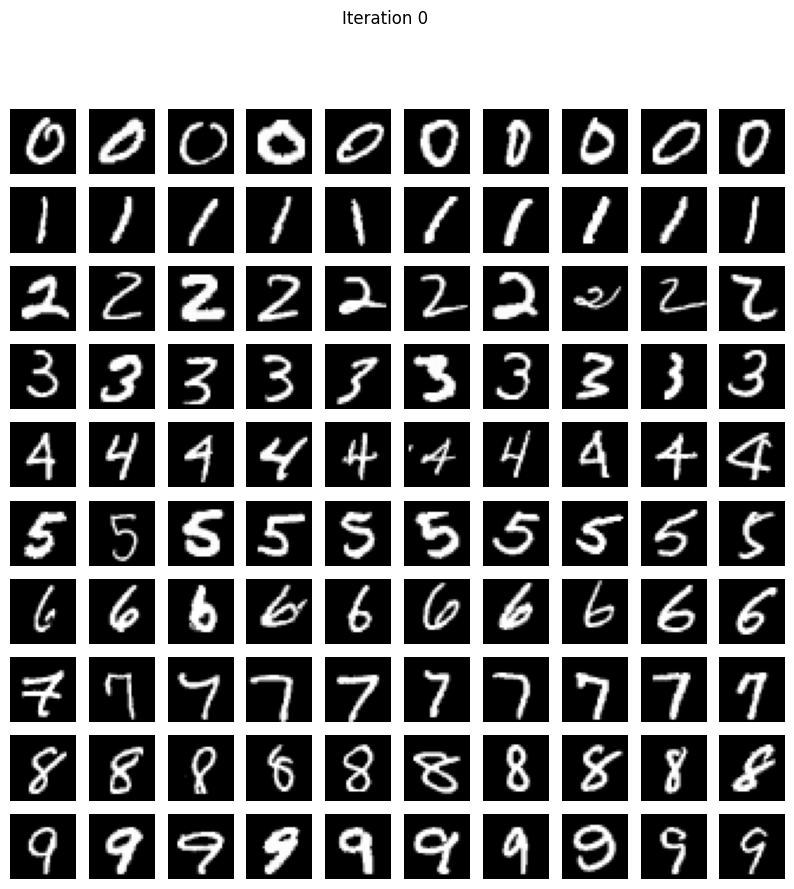

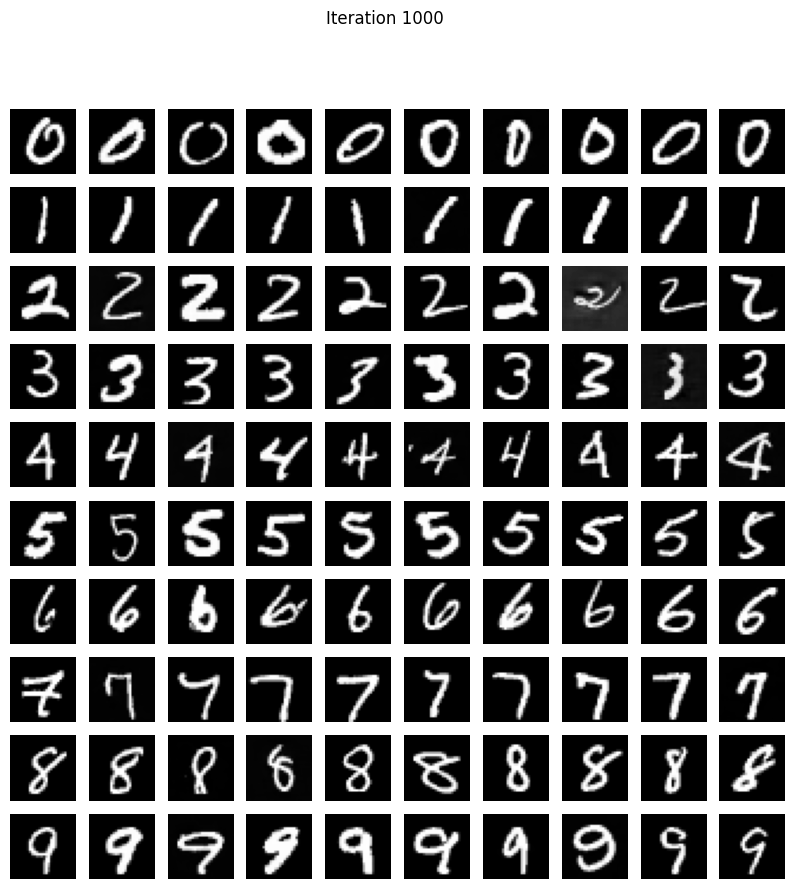

In [ ]:
# Load the synthetic dataset
synthetic_data = torch.load('/content/drive/MyDrive/Colab Notebooks/ECE1512/Project B/Task2_Synthetic_Dataset/Task2_Lossless_Dataset.pt')

synthetic_images = {
    'Iteration 0': synthetic_data[0][0],
    'Iteration 1000': synthetic_data[10][0]
}

# Plot
for iteration, images in synthetic_images.items():

    # 1200 images per class is too much to show, I only show 10 images per class
    # for illustration purpose
    fig, axes = plt.subplots(nrows=num_classes, ncols=10, figsize=(10, num_classes))
    fig.suptitle(iteration)

    # Iterate over each class
    for class_idx in range(num_classes):
        # Select 10 images from each class
        selected_images = images[class_idx * ipc : class_idx * ipc + 10]

        # Plot each image
        for img_idx, ax in enumerate(axes[class_idx]):
            img = selected_images[img_idx].numpy().squeeze()
            ax.imshow(img, cmap='gray')
            ax.axis('off')

    print("\n")
    plt.show()

**Train on synthetic dataset**

In [ ]:
batch_size_MNIST = 256
num_workers = 0

channel, im_size, num_classes, class_names, mean, std, train_MNIST_dataset, test_MNIST_dataset, test_MNIST_dataloader = get_dataset('MNIST', './data')
class_map = {x:x for x in range(num_classes)}

ConvNet3 = get_network('ConvNet', channel=channel, num_classes=num_classes, im_size=im_size)

def SoftCrossEntropy(inputs, target, reduction='average'):
    input_log_likelihood = -F.log_softmax(inputs, dim=1)
    target_log_likelihood = F.softmax(target, dim=1)
    batch = inputs.shape[0]
    loss = torch.sum(torch.mul(input_log_likelihood, target_log_likelihood)) / batch
    return loss

In [ ]:
image_syn = synthetic_data[10][0]
label_syn = synthetic_data[10][1]
lr_syn = float(synthetic_data[10][2])

dst_syn_train = TensorDataset(image_syn, label_syn)
trainloader = torch.utils.data.DataLoader(dst_syn_train, batch_size=batch_size_MNIST, shuffle=True, num_workers=0)

num_epochs = 20
num_training_steps = num_epochs * len(trainloader)
train_criterion = SoftCrossEntropy
# train_criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(ConvNet3.parameters(), lr=lr_syn, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

start_time = time.time()
progress_bar = tqdm(range(num_training_steps),
                    bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{rate_fmt}{postfix}]')

for epoch in range(num_epochs):

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        outputs = ConvNet3(images)
        loss = train_criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        progress_bar.update(1)
        precise_elapsed_time = time.time() - start_time
        progress_bar.set_description(f"Elapsed Time: {precise_elapsed_time:.2f} seconds")

    if (epoch+1) % 5 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

progress_bar.close()

  0%|          | 0/2360 [?it/s]

Epoch 5, Loss: 0.0799
Epoch 10, Loss: 0.0368
Epoch 15, Loss: 0.0609
Epoch 20, Loss: 0.0525


In [ ]:
print(progress_bar.desc)

Elapsed Time: 29.14 seconds: 


In [ ]:
ConvNet3.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_MNIST_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = ConvNet3(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the 10000 test images: {accuracy:.2f} %')

Accuracy of the model on the 10000 test images: 99.10 %


**Train on original dataset**

In [ ]:
num_epochs = 20
ConvNet3 = get_network('ConvNet', channel=channel, num_classes=num_classes, im_size=im_size)
train_MNIST_dataloader = torch.utils.data.DataLoader(dataset=train_MNIST_dataset, batch_size=batch_size_MNIST, shuffle=True, num_workers=num_workers)
num_training_steps_MNIST = num_epochs * len(train_MNIST_dataloader)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(ConvNet3.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# Training
start_time = time.time()
progress_bar = tqdm(range(num_training_steps_MNIST),
                    bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{rate_fmt}{postfix}]')

for epoch in range(num_epochs):
    for images, labels in train_MNIST_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = ConvNet3(images)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

        precise_elapsed_time = time.time() - start_time
        progress_bar.set_description(f"Elapsed Time: {precise_elapsed_time:.2f} seconds")

    if (epoch+1) % 5 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

progress_bar.close()

  0%|          | 0/4700 [?it/s]

Epoch 5, Loss: 0.0275
Epoch 10, Loss: 0.0608
Epoch 15, Loss: 0.0087
Epoch 20, Loss: 0.0156


In [ ]:
print(progress_bar.desc)

Elapsed Time: 291.79 seconds: 


In [ ]:
ConvNet3.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_MNIST_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = ConvNet3(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the 10000 test images: {accuracy:.2f} %')

Accuracy of the model on the 10000 test images: 99.38 %
